In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from pyhmc_minimal.hmcparameter import HMCParameter
from pyhmc_minimal.hmc import HMC

### Examples for the implementation of different known distributions for the hmcparameter class

In [2]:
class StateMultivarNormal(HMCParameter):

    def __init__(self, init_val, mu=0, sigma_inv=1):
        super().__init__(np.array(init_val))
        self.mu = mu
        self.sigma_inv = sigma_inv

    def get_energy_grad(self):
        return np.dot(self.sigma_inv, (self.value - self.mu))
    
    def energy(self, value):
        return np.dot((value - self.mu).transpose(), np.dot(self.sigma_inv, (value - self.mu))) / 2
    
    def get_energy(self):
        return self.energy(self.value)
    
    def get_energy_for_value(self, value):
        return self.energy(value)
    
    
class StateExpDist(HMCParameter):

    def __init__(self, init_val, gamma):
        super().__init__(np.array(init_val))
        self.gamma = gamma

    def get_energy_grad(self, *args):
        return self.gamma
    
    def energy(self, value):
        if value <= 0:
            return np.inf
        else:
            return self.gamma * value
        
    def get_energy(self):
        return self.energy(self.value)
    
    def get_energy_for_value(self, value):
        return self.energy(value)
    

class StateInvGamma(HMCParameter):

    def __init__(self, init_val, alpha, betta):
        super().__init__(np.array(init_val))
        self.alpha = alpha
        self.betta = betta

    def get_energy_grad(self):
        return (self.alpha + 1) / self.value - self.betta / (self.value ** 2)
    
    def energy(self, value):
        if value <= 0:
            return np.inf
        else:
            return (self.alpha + 1) * np.log(value) + self.betta / value
    
    def get_energy(self):
        return self.energy(self.value)
    
    def get_energy_for_value(self, value):
        return self.energy(value)
    
    
class StateLapDist(HMCParameter):

    def __init__(self, init_val):
        super().__init__(np.array(init_val))

    def get_energy_grad(self):
        return 1 if self.value > 0 else -1
    
    def energy(self, value):
        return abs(value)
    
    def get_energy(self):
        return self.energy(self.value)
    
    def get_energy_for_value(self, value):
        return self.energy(value)
    

class StatebettaDist(HMCParameter):

    def __init__(self, init_val, alpha, betta):
        super().__init__(np.array(init_val))
        self.alpha = alpha
        self.betta = betta

    def get_energy_grad(self):
        return (1 - self.alpha) / self.value + (self.betta - 1) / (1 - self.value)
    
    def energy(self, value):
        if value < 0 or value > 1:
            return np.inf
        else:
            return (1 - self.alpha) * np.log(value) + (1 - self.betta) * np.log(1 - value)
    
    def get_energy(self):
        return self.energy(self.value)
    
    def get_energy_for_value(self, value):
        return self.energy(value)

### Implementation for the default velocity parameter with a Gaussian distribution

In [3]:
class VelParam(HMCParameter):

    def __init__(self, init_val):
        super().__init__(np.array(init_val))
        dim = np.array(init_val).shape
        self.mu = np.zeros(dim)
        self.sigma = np.identity(dim[0])

    def gen_init_value(self):
        self.value = multivariate_normal.rvs(self.mu, self.sigma)

    def get_energy_grad(self):
        return self.value
    
    def energy(self, value): 
        return np.dot(value, value) / 2
    
    def get_energy(self):
        return self.energy(self.value)
    
    def get_energy_for_value(self, value):
        return self.energy(value)

### Example for creating instances for the state and velocity and running the hmc algorithm for multivariate Gaussian distribution

In [4]:
state = StateMultivarNormal([1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7], np.identity(6))
vel = VelParam(np.array([1, 1, 1, 1, 1, 1]))

In [5]:
delta = 1
n = 10
m = 10000

In [6]:
hmc = HMC(state, vel, delta, n, m) # create an instance of the HMC class
hmc.HMC() # Run the HMC algorithm

In [7]:
res = np.array(hmc.get_samples()) # Getting the chain of samples for the state parameter

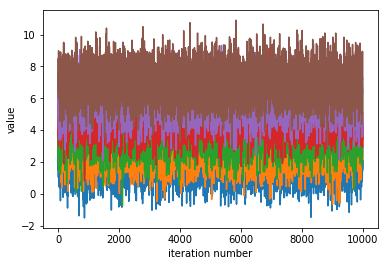

In [8]:
# Plotting the chains for each dimension of the multivariate Gaussian
plt.plot(res)
plt.xlabel('iteration number')
plt.ylabel('value')
plt.show()

/home/noashin/.pyenv/versions/3.6.5/envs/B03/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


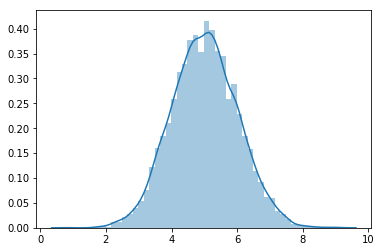

In [9]:
# Looking at the samples for one variate as a histogram
sns.distplot(res[:,3])
plt.show()

In [11]:
# looking at the acceptance rate
print('Acceptance rate: %f' %hmc.calc_acceptence_rate())

Acceptance rate: 0.770700
